In [2]:
from tqdm import tqdm
import numpy as np
from copy import deepcopy
import reservoir as rsv
from recover.utils.utils import get_tensor_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import json
import sys
import os
import pandas as pd
import torch
import importlib
import scipy
# import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


/Users/farzanehlabbaf/miniconda3/envs/recover_new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
drugs = rsv.get_drugs()

# Get the available DTI files
available_dtis = rsv.available_dtis()

# Get the chembl binding dtis
chembl_dtis = rsv.get_dtis('chembl_dtis.csv')

# print(chembl_dtis)

In [4]:
# returns all the proteins with inter db identifiers
proteins = rsv.get_proteins()

# get the available ppi files
availabe_ppis = rsv.available_ppis()

# get the huri ppis
huri_ppi = rsv.get_ppis("huri.csv")

# get ppi involving the ACE2 and NFE2L2 proteins
rsv.get_ppis("biogrid.csv", gene_hgnc_ids=['ACE2', 'NFE2L2'])

,gene_1_hgnc_id,gene_2_hgnc_id,Experimental System,Experimental System Type,Author,Publication Source
434,CREBBP,NFE2L2,Two-hybrid,physical,Katoh Y (2001),PUBMED:11683914
477,PMF1,NFE2L2,Two-hybrid,physical,Wang Y (1999),PUBMED:10419538
478,EIF2AK3,NFE2L2,Two-hybrid,physical,Cullinan SB (2003),PUBMED:14517290
9758,EIF2AK3,NFE2L2,Biochemical Activity,physical,Cullinan SB (2003),PUBMED:14517290
9759,KEAP1,NFE2L2,Reconstituted Complex,physical,Cullinan SB (2003),PUBMED:14517290
...,...,...,...,...,...,...
556780,KEAP1,NFE2L2,Affinity Capture-Western,physical,Wan ZH (2020),PUBMED:31541481
557966,NFE2L2,KEAP1,Affinity Capture-Western,physical,Wang J (2019),PUBMED:31695040
557969,KEAP1,NFE2L2,Affinity Capture-Western,physical,Wang J (2019),PUBMED:31695040
558123,MAPK8,NFE2L2,Biochemical Activity,physical,Chen Y (2020),PUBMED:31945188


In [5]:
all_blocks = rsv.get_specific_drug_combo_blocks(combo_measurements=9, mono_row_measurements=4, mono_col_measurements=4)
all_blocks

,Unnamed: 0,block_id,detection_technology,time_h,study_name,combo_measurements,mono_row_measurements,mono_col_measurements,cell_line_name
117834,117834,132370,NaN,48,ALMANAC,9,4,4,K-562
117835,117835,132372,NaN,48,ALMANAC,9,4,4,MDA-MB-468
117836,117836,132374,NaN,48,ALMANAC,9,4,4,SNB-75
117837,117837,132375,NaN,48,ALMANAC,9,4,4,OVCAR3
117838,117838,132376,NaN,48,ALMANAC,9,4,4,SK-MEL-28
...,...,...,...,...,...,...,...,...,...
378341,378341,432461,NaN,48,ALMANAC,9,4,4,SK-MEL-5
378342,378342,432462,NaN,48,ALMANAC,9,4,4,SK-MEL-28
378343,378343,432463,NaN,48,ALMANAC,9,4,4,OVCAR3
378344,378344,432464,NaN,48,ALMANAC,9,4,4,MDA-MB-231


In [6]:
mono_data = rsv.get_drug_combo_data_monos(block_ids=all_blocks['block_id'])

# Show the data for the row drug
# print(mono_data[['block_id', 'conc_r', 'inhibition_r']])

# Show the data for the col drug
# print(mono_data[['block_id', 'conc_c', 'inhibition_c']])

# These can be stacked as they are numpy arrays
import numpy as np
np.stack(mono_data['inhibition_r'])
mono_data

,block_id,cell_line_name,drug_row_recover_id,drug_row_smiles,conc_r,inhibition_r,drug_col_recover_id,drug_col_smiles,conc_c,inhibition_c
117834,132370,K-562,RE-MOL-0000318902,Sc1ncnc2nc[nH]c12,"[0.0, 0.02, 0.2, 2.0]","[-0.0006264538000000001, -10.4198163567, 4.139...",RE-MOL-0001086878,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,"[0.0, 0.001, 0.01, 0.1]","[-0.0006264538000000001, -1.7696704922, 0.6505..."
117835,132372,MDA-MB-468,RE-MOL-0000017147,Nc1nc(Cl)nc2c1ncn2C1CC(O)C(CO)O1,"[0.0, 0.01, 0.1, 1.0]","[-0.0006264538000000001, 0.7601836433, -3.9808...",RE-MOL-0000575645,C/C(=C\c1csc(C)n1)[C@@H]1C[C@@H]2O[C@]2(C)CCC[...,"[0.0, 0.003, 0.03, 0.30000000000000004]","[-0.0006264538000000001, 2.3503295078, 53.0105..."
117836,132374,SNB-75,RE-MOL-0000046105,Cn1nnc2c(C(N)=O)ncn2c1=O,"[0.0, 0.2, 2.0, 20.0]","[-0.0006264538000000001, -3.9498163567, 2.5591...",RE-MOL-0000002081,CCN(CC)CCCC(C)Nc1c2ccc(Cl)cc2nc2ccc(OC)cc12,"[0.0, 0.03, 0.30000000000000004, 3.0]","[-0.0006264538000000001, -1.1296704922, 1.3805..."
117837,132375,OVCAR3,RE-MOL-0000000470,O=c1[nH]c(=O)n(C2CC(O)C(CO)O2)cc1F,"[0.0, 0.0007, 0.007, 0.07]","[-0.0006264538000000001, 20.8901836433, 4.9691...",RE-MOL-0000017147,Nc1nc(Cl)nc2c1ncn2C1CC(O)C(CO)O1,"[0.0, 0.01, 0.1, 1.0]","[-0.0006264538000000001, 0.3203295078, -0.3194..."
117838,132376,SK-MEL-28,RE-MOL-0000043950,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1,"[0.0, 0.01, 0.1, 1.0]","[-0.0006264538000000001, 9.0901836433, 13.2791...",RE-MOL-0000166485,Nc1ncn(C2CC(O)C(CO)O2)c(=O)n1,"[0.0, 0.003, 0.03, 0.30000000000000004]","[-0.0006264538000000001, -0.9896704922, -2.919..."
...,...,...,...,...,...,...,...,...,...,...
378341,432461,SK-MEL-5,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,"[0.0, 0.1, 1.0, 10.0]","[-0.0006264538000000001, 2.365184, 2.409164, 4...",RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[0.0, 0.15, 1.5, 15.0]","[-0.0006264538000000001, -8.13367, -7.866424, ..."
378342,432462,SK-MEL-28,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,"[0.0, 0.1, 1.0, 10.0]","[-0.0006264538000000001, 4.295184, 0.5011644, ...",RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[0.0, 0.15, 1.5, 15.0]","[-0.0006264538000000001, -2.72567, -2.592424, ..."
378343,432463,OVCAR3,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,"[0.0, 0.1, 1.0, 10.0]","[-0.0006264538000000001, 7.835929, 16.40316, 3...",RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[0.0, 0.15, 1.5, 15.0]","[-0.0006264538000000001, 3.17733, -1.372424, 6..."
378344,432464,MDA-MB-231,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,"[0.0, 0.1, 1.0, 10.0]","[-0.0006264538000000001, 2.787184, 2.185664, 1...",RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[0.0, 0.15, 1.5, 15.0]","[-0.0006264538000000001, -1.10617, -3.587424, ..."


In [7]:
combo_data = rsv.get_drug_combo_data_combos(block_ids=all_blocks['block_id'])

# The inhibition measurements from the combination matrix are here as a list
combo_data[['block_id', 'inhibitions']]

# The concentration for the combination matrix are here, each tuple is  (row drug, column drug). They map by index to the inhibitions
combo_data[['block_id', 'concentration_pairs']]

# Synergy scores
combo_data[['block_id', 'css_ri', 'synergy_zip', 'synergy_bliss', 'synergy_loewe', 'synergy_hsa', 'S']]
combo_data

,block_id,cell_line_name,drug_row_recover_id,drug_row_smiles,drug_col_recover_id,drug_col_smiles,concentration_pairs,inhibitions,css_ri,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa,S
117834,132370,K-562,RE-MOL-0000318902,Sc1ncnc2nc[nH]c12,RE-MOL-0001086878,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,"[[0.02, 0.001], [0.02, 0.01], [0.02, 0.1], [0....","[-16.4308204684, 5.7496946116, 1.7277853000999...",-2.96,0.67,-0.25,-4.42,-4.50,-2.45
117835,132372,MDA-MB-468,RE-MOL-0000017147,Nc1nc(Cl)nc2c1ncn2C1CC(O)C(CO)O1,RE-MOL-0000575645,C/C(=C\c1csc(C)n1)[C@@H]1C[C@@H]2O[C@]2(C)CCC[...,"[[0.01, 0.003], [0.01, 0.03], [0.01, 0.3000000...","[6.7791795316, 53.4596946116, 73.4777853001, 7...",40.41,0.09,0.54,-9.74,1.35,-4.03
117836,132374,SNB-75,RE-MOL-0000046105,Cn1nnc2c(C(N)=O)ncn2c1=O,RE-MOL-0000002081,CCN(CC)CCCC(C)Nc1c2ccc(Cl)cc2nc2ccc(OC)cc12,"[[0.2, 0.03], [0.2, 0.30000000000000004], [0.2...","[-1.7808204684, -1.6903053884, 14.4277853001, ...",3.19,-3.23,-0.17,-4.85,-0.77,-3.39
117837,132375,OVCAR3,RE-MOL-0000000470,O=c1[nH]c(=O)n(C2CC(O)C(CO)O2)cc1F,RE-MOL-0000017147,Nc1nc(Cl)nc2c1ncn2C1CC(O)C(CO)O1,"[[0.0007, 0.01], [0.0007, 0.1], [0.0007, 1.0],...","[22.5991795316, 0.019694611600000002, 30.71778...",18.84,-6.14,-7.06,-10.66,-3.94,0.20
117838,132376,SK-MEL-28,RE-MOL-0000043950,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1,RE-MOL-0000166485,Nc1ncn(C2CC(O)C(CO)O2)c(=O)n1,"[[0.01, 0.003], [0.01, 0.03], [0.01, 0.3000000...","[5.7991795316, -1.5003053884000002, 6.42778530...",36.06,2.37,5.90,-0.38,4.00,16.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378341,432461,SK-MEL-5,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[[0.1, 0.15], [0.1, 1.5], [0.1, 15.0], [1.0, 0...","[2.78318, 1.6096949999999999, 4.001785, -2.534...",31.47,-7.05,3.66,-23.05,-0.29,22.54
378342,432462,SK-MEL-28,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[[0.1, 0.15], [0.1, 1.5], [0.1, 15.0], [1.0, 0...","[0.2051795, 1.558695, 1.883785, 6.154487, 8.20...",14.24,-3.96,0.60,-2.54,-0.29,9.09
378343,432463,OVCAR3,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[[0.1, 0.15], [0.1, 1.5], [0.1, 15.0], [1.0, 0...","[13.50018, 8.614695, 6.758785, 16.59849, 18.90...",30.87,-4.21,-0.75,-9.54,1.49,7.71
378344,432464,MDA-MB-231,RE-MOL-0000075347,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,RE-MOL-0000009357,O=NN(CCCl)C(=O)NCCCl,"[[0.1, 0.15], [0.1, 1.5], [0.1, 15.0], [1.0, 0...","[4.20818, 3.415695, 10.58179, 0.9124874, 0.967...",14.32,-5.66,-2.00,-5.79,-1.52,7.21


(array([1.0000e+00, 1.0000e+00, 3.0000e+00, 7.0000e+00, 1.6000e+01,
        1.1000e+01, 2.4000e+01, 3.0000e+01, 6.2000e+01, 8.7000e+01,
        1.2100e+02, 1.8100e+02, 2.5200e+02, 3.5200e+02, 4.5900e+02,
        7.2500e+02, 9.6400e+02, 1.4520e+03, 2.0780e+03, 3.0040e+03,
        4.6440e+03, 6.7620e+03, 1.0787e+04, 2.0200e+04, 3.9201e+04,
        4.8414e+04, 3.6401e+04, 2.4589e+04, 1.7043e+04, 1.1642e+04,
        8.0750e+03, 5.5490e+03, 3.7610e+03, 2.6370e+03, 1.8340e+03,
        1.2810e+03, 9.1800e+02, 5.9000e+02, 3.5400e+02, 2.3100e+02,
        1.1500e+02, 8.8000e+01, 4.5000e+01, 2.2000e+01, 1.5000e+01,
        9.0000e+00, 4.0000e+00, 6.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-9.3590e+01, -8.9845e+01, -8.6100e+01, -8.2355e+01, -7.8610e+01,
        -7.4865e+01, -7.1120e+01, -6.7375e+01, -6.3630e+01, -5.9885e+01,
        -5.6140e+01, -5.2395e+01, -4.8650e+01, -4.4905e+01, -4.1160e+01,
        -3.7415e+01, -3.3670e+01, -2.9925e+01, -2.6180e+01, -2.2435e+01,
        -1.8690e+01, -1.49

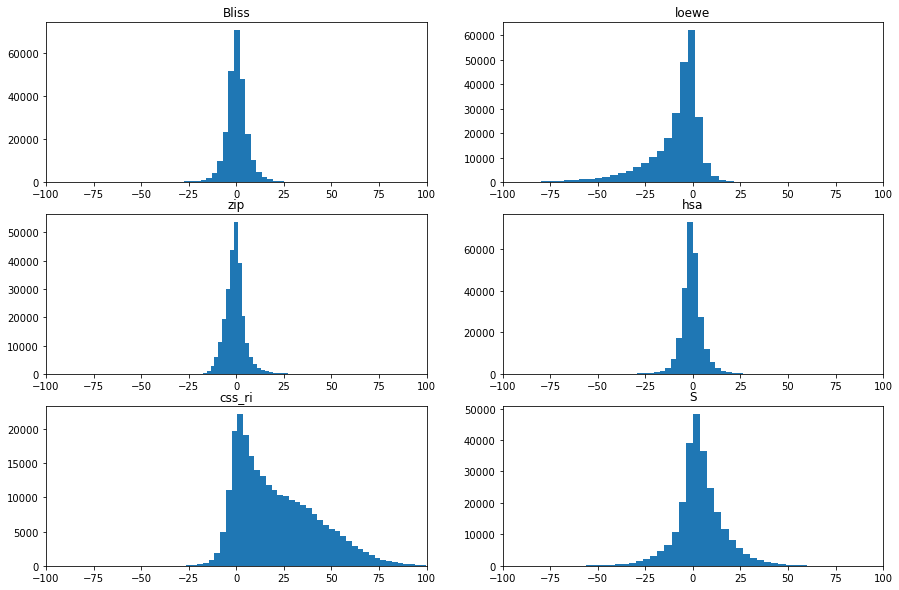

In [75]:
combo_data_filtered = combo_data[['block_id', 'drug_row_recover_id', 'drug_col_recover_id','inhibitions' ,'css_ri', 'synergy_zip', 'synergy_bliss', 'synergy_loewe', 'synergy_hsa', 'S']]

plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
plt.xlim(-100, 100)
plt.title("Bliss")
plt.hist(combo_data[['synergy_bliss']], bins=50)
plt.subplot(3,2,2)
plt.xlim(-100, 100)
plt.title("loewe")
plt.hist(combo_data[['synergy_loewe']], bins=50)
plt.subplot(3,2,3)
plt.xlim(-100, 100)
plt.title("zip")
plt.hist(combo_data[['synergy_zip']], bins=50)
plt.subplot(3,2,4)
plt.xlim(-100, 100)
plt.title("hsa")
plt.hist(combo_data[['synergy_hsa']], bins=50)
plt.subplot(3,2,5)
plt.xlim(-100, 100)
plt.title("css_ri")
plt.hist(combo_data[['css_ri']], bins=50)
plt.subplot(3,2,6)
plt.xlim(-100, 100)
plt.title("S")
plt.hist(combo_data[['S']], bins=50)


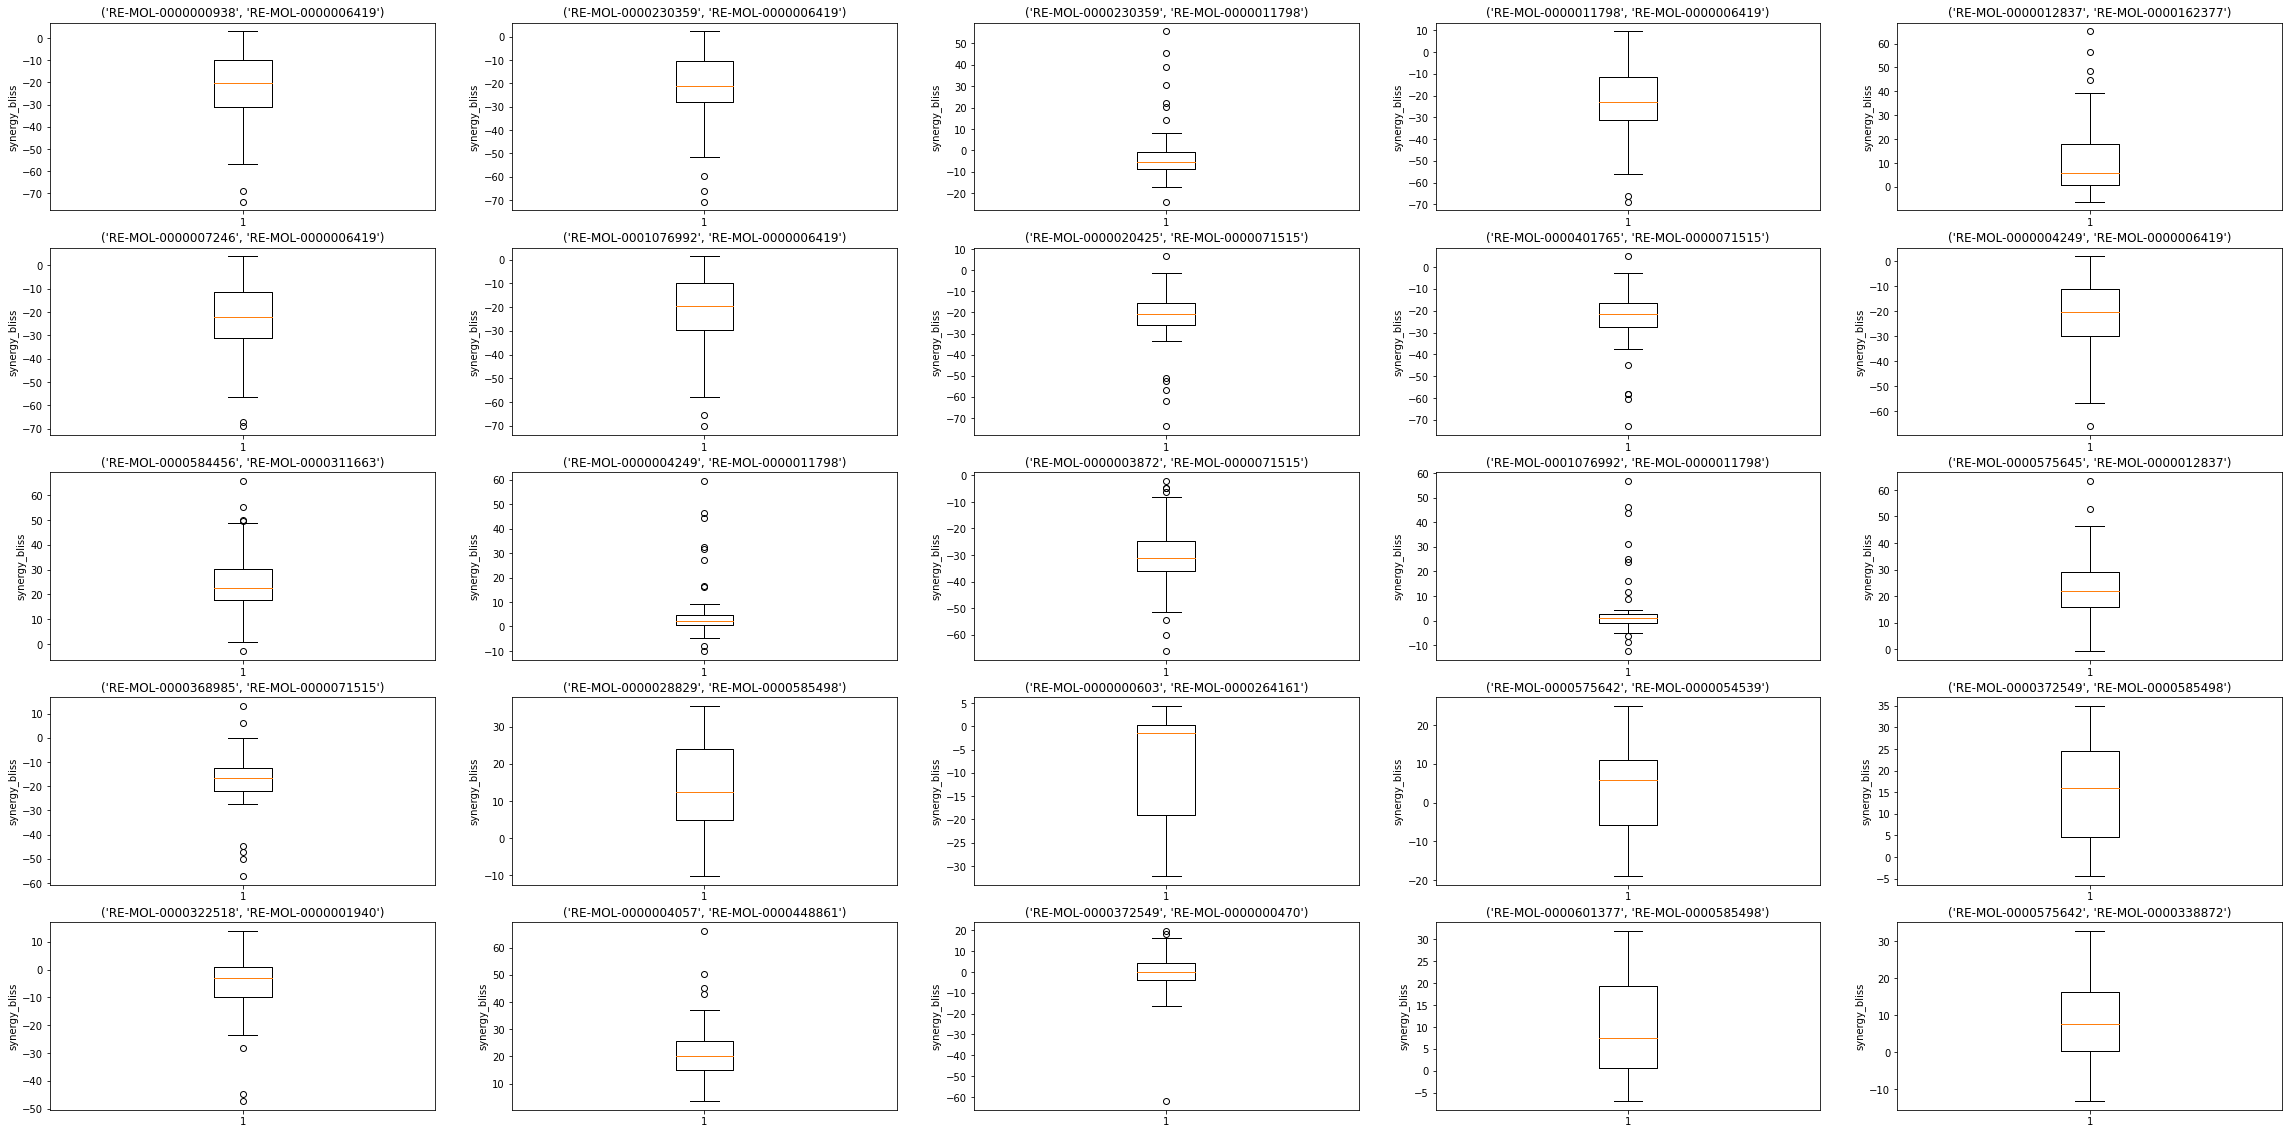

In [97]:
c = combo_data[['drug_row_recover_id', 'drug_col_recover_id','synergy_bliss', 'synergy_loewe', ]].groupby(by = ["drug_row_recover_id", "drug_col_recover_id"])
top_std = c.std().sort_values(by='synergy_bliss', ascending=False)
i =0
n = 5
plt.figure(figsize=(40,20))
for k in top_std.iterrows():
    i+=1
    if(i>n*n):
        break
    index = k[0]
    # print(k[0])
    # print(gp)
    gp=c.get_group(index)
    plt.subplot(n, n,i)
    plt.title(index)
    plt.ylabel("synergy_bliss")
    plt.boxplot(gp['synergy_bliss'])


In [ ]:
c = combo_data[['drug_row_recover_id', 'drug_col_recover_id','synergy_bliss', 'synergy_loewe', ]].groupby(by = ["drug_row_recover_id", "drug_col_recover_id"])
top_std = c.std().sort_values(by='synergy_bliss', ascending=False)
i =0
n = 5
plt.figure(figsize=(20,20))
for k in top_std.iterrows():
    i+=1
    if(i>n*n):
        break
    index = k[0]
    # print(k[0])
    # print(gp)
    gp=c.get_group(index)
    plt.subplot(n, n,i)
    plt.title(index)
    plt.boxplot(gp['synergy_bliss'])


In [ ]:

c = combo_data_filtered.groupby(by = ["drug_row_recover_id", "drug_col_recover_id"])
i = 0
plt.figure(figsize=(20,20))
import random
group_count = len(c)
# sample_groups = c.sample(n=4)
x = 2
n = random.sample(range(0,group_count),x*x)
print(n)
j = 0
for k , gp in c:
    if(i in n):
        print("i")
        j+=1
    # rand_index = combo_data_filtered[['drug_row_recover_id', 'drug_col_recover_id']]
    # x = rand_index[n]
    # print(rand_index)
#     k , gp = c[n]
        inhibition = gp['inhibitions']
        lable1,lable2 = k
        print(lable1+" and " +lable2)
        synergy_bliss = gp['synergy_bliss']
        synergy_loewe = gp['synergy_loewe']
        plt.subplot(x, x, j)
        plt.boxplot(synergy_bliss,)    
        # plt.boxplot(synergy_loewe)    

    i+=1
plt.legend();